In [1]:
# 패키지 설치 및 작동 확인
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


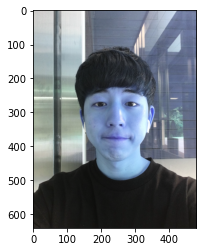

In [2]:
# 준비한 이미지 읽기 및 리사이징
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/new.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 360x640의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

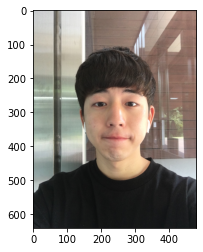

In [3]:
# BGR -> RGB로 변환 (opencv는 bgr 순으로 읽는다.)
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
# hog detector 선언 
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

# 얼굴 찾아내기 전 bgr -> rgb 변환 / unsampling을 통해 이미지 키우기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸
🌫🛸


rectangles[[(142, 217) (365, 440)]]


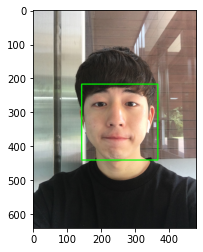

In [5]:
# 얼굴영역 사진에 표시하기

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
# l = 142 / t = 217 / r = 365 / b = 440 
# l은 얼굴을 찾는 영역에서 좌측 변 x값 위치
# t는 얼굴 찾는 영역에서 위측 변 y값 위치 
# r은 얼굴을 찾는 영역에서 우측 변 x값 위치
# b는 얼굴 찾는 영역에서 아래쪽 변 y값 위치 

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [6]:
# 이목구비를 찾기 위해 landmark 불러오기

import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [7]:
# 얼굴에서 68개의 랜드마크 찾기 (이목구비를 표시하는 노란점)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


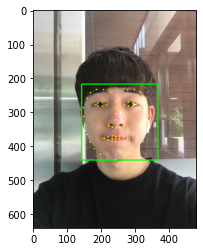

In [8]:
# 사진에 찾은 랜드마크 출력하기

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(241, 322)
(x,y) : (241,210)
(w,h) : (224,224)
(224, 224, 3)
(x,y) : (129,-14)
(210, 224, 3)
(x,y) : (129,0)


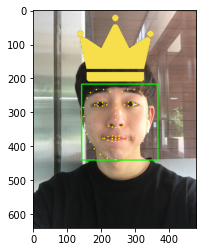

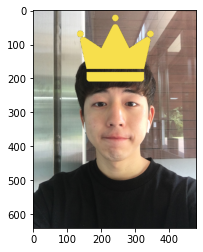

In [9]:
# 왕관을 씌우기 위해 거리값 계산 (비율로 계산)

# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30 // 코 중심점
    x = landmark[30][0] # 코의 x축 위치
    y = landmark[30][1] - dlib_rect.width()//2 # 코의 축 위치
    
    # y값은 위에서부터 값이 시작하기 때문에 빼기(-)를 통해 스티커가 들어갈 위치를 높이는 것
    # dlib_rect.width()//2 은 스티커의 크기의 절반을 의미. 즉 코를 기준으로 전체 스티커 크기의 절반만큼 y축 상승 
    
    w = dlib_rect.width() # 스티커의 밑변 길이
    h = dlib_rect.width() # 스티커의 높이
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
    
# 사진에 맞게 왕관 이미지 리사이징
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

# 스티커 이미지를 추가하기 위해 x,y좌표 조정 -> 음수값이 출력되었다면 스티커 범위가 사진 범위를 넘은 것
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 사진 범위를 넘은 스티커 부분 제거
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

# top의 y 좌표는 원본 이미지의 경계값으로 수정
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 바운더리 및 랜드마크 제거
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

